# Random Forest

In [6]:
# Importações
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier

# Leitura dos dados
df = pd.read_csv('C:/Users/natha/Downloads/RES_IA/outputs/chapa-treino.csv')

# Features criadas
df['relacao_log_variacao'] = df['log_das_areas'] / (df['indice_de_variacao_x'] + 1)
df['area_por_orientacao'] = df['area_pixels'] / (df['indice_de_orientaçao'] + 1)
df['lum_por_borda'] = df['soma_da_luminosidade'] / (df['index_de_bordas'] + 1)
df['intensidade_normalizada'] = df['soma_da_luminosidade'] / (df['comprimento_do_transportador'] + 1)
df['densidade_area'] = df['area_pixels'] / (df['index_quadrado'] + 1)

# Colunas de falha
colunas_falha = ['falha_1', 'falha_2', 'falha_3', 'falha_4', 'falha_5', 'falha_6', 'falha_outros']

# Geração da coluna alvo
if 'classe_defeito' not in df.columns:
    df['classe_defeito'] = df[colunas_falha].idxmax(axis=1)

# Garantir tipo inteiro nas falhas
for col in colunas_falha:
    df[col] = df[col].astype(int)

# Separação em X e y
X = df.drop(columns=colunas_falha + ['classe_defeito'])
y = df['classe_defeito']

# Identificação dos tipos de coluna
numericas = X.select_dtypes(include='number').columns.tolist()
categoricas = X.select_dtypes(include='object').columns.tolist()

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Pipelines de pré-processamento
numerico = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorico = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessador = ColumnTransformer([
    ('num', numerico, numericas),
    ('cat', categorico, categoricas)
])

# Instanciando SMOTE
smote = SMOTE(random_state=42)

# Pipeline final com Random Forest + SMOTE
modelo_final = ImbPipeline(steps=[
    ('preprocessador', preprocessador),
    ('smote', smote),
    ('classificador', RandomForestClassifier(
        n_estimators=100,
        criterion='gini',
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=42
    ))
])

# Treinamento
modelo_final.fit(X_train, y_train)

# Predição e avaliação
y_pred = modelo_final.predict(X_test)
print("\nRelatório de Classificação:\n")
print(classification_report(y_test, y_pred))


Relatório de Classificação:

              precision    recall  f1-score   support

     falha_1       0.45      0.64      0.53        55
     falha_2       0.78      0.89      0.83        53
     falha_3       0.95      0.93      0.94       130
     falha_4       0.73      0.96      0.83        23
     falha_5       0.40      0.53      0.45        19
     falha_6       0.57      0.57      0.57       161
falha_outros       0.69      0.58      0.63       237

    accuracy                           0.68       678
   macro avg       0.65      0.73      0.68       678
weighted avg       0.69      0.68      0.68       678



In [7]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'classificador__n_estimators': [100, 200],
#     'classificador__max_depth': [10, 20, None],
#     'classificador__min_samples_split': [2, 5],
#     'classificador__min_samples_leaf': [1, 2],
#     'classificador__criterion': ['gini', 'entropy']
# }

# grid = GridSearchCV(
#     modelo_final, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1
# )
# grid.fit(X_train, y_train)

# print("Melhores parâmetros:", grid.best_params_)
# Resultado: Melhores parâmetros: {'classificador__criterion': 'gini', 'classificador__max_depth': None, 'classificador__min_samples_leaf': 2, 'classificador__min_samples_split': 2, 'classificador__n_estimators': 100}


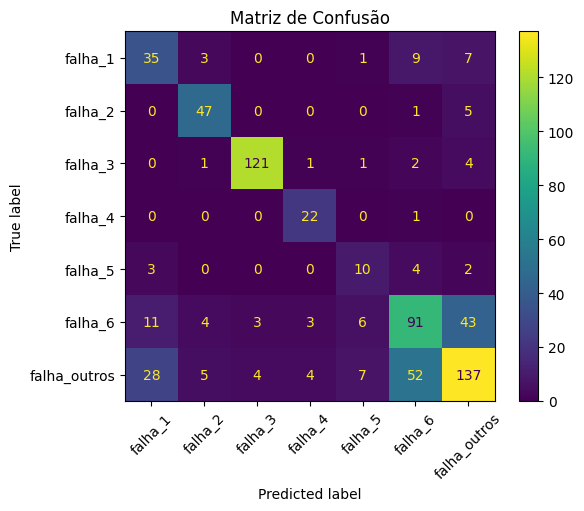

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(modelo_final, X_test, y_test, xticks_rotation=45)
plt.title("Matriz de Confusão")
plt.show()

In [9]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(modelo_final, X, y, cv=5, scoring='f1_weighted')
print(f"F1 médio: {scores.mean():.4f} ± {scores.std():.4f}")

F1 médio: 0.6528 ± 0.0599


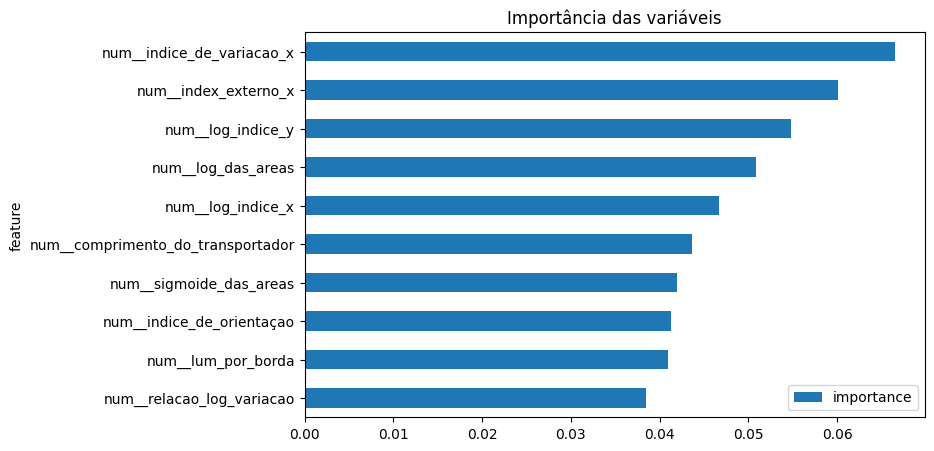

In [10]:
# Após o fit
modelo_rf = modelo_final.named_steps['classificador']
importancias = modelo_rf.feature_importances_
nomes = preprocessador.get_feature_names_out()
importancias_df = pd.DataFrame({'feature': nomes, 'importance': importancias}).sort_values(by='importance', ascending=False)

# Top 10
importancias_df.head(10).plot(kind='barh', x='feature', y='importance', figsize=(8, 5), title='Importância das variáveis')
plt.gca().invert_yaxis()
plt.show()